In [0]:
import pyspark
import mlflow
import catboost
import json
import math
import pandas as pd
import pyspark.sql.functions as F
from sklearn.model_selection import train_test_split

from src.modeling import FrequencyModeling

print(mlflow.__version__)

2.22.0


In [0]:
CATALOG = "workspace"
SCHEMA = "safe_driver_prediction"
VOLUME = "kaggle_competition_data"
CONFIG_PATH = "./configs/freq_model_pipeline_v1.0.json"

with open(CONFIG_PATH, mode="r") as f:
    config = json.load(f)

training_params = config["training_parameters"]
modeling_params = config["modeling_parameters"]
run_params = config["run_parameters"]

print("run description:", run_params["run_description"])

run description: decrease test ratio from 0.3 to 0.15


In [0]:
fs_df = spark.table(training_params["feature_store_path"])

print(f"training set has {fs_df.count()} rows and {len(fs_df.columns)} columns.")
fs_df.limit(10).display()

training set has 595212 rows and 63 columns.


id,target,ind_01,ind_02_cat,ind_03,ind_04_cat,ind_05_cat,ind_06_bin,ind_07_bin,ind_08_bin,ind_09_bin,ind_10_bin,ind_11_bin,ind_12_bin,ind_13_bin,ind_14,ind_15,ind_16_bin,ind_17_bin,ind_18_bin,reg_01,reg_02,reg_03,car_01_cat,car_02_cat,car_03_cat,car_04_cat,car_05_cat,car_06_cat,car_07_cat,car_08_cat,car_09_cat,car_10_cat,car_11_cat,car_11,car_12,car_13,car_14,car_15,calc_01,calc_02,calc_03,calc_04,calc_05,calc_06,calc_07,calc_08,calc_09,calc_10,calc_11,calc_12,calc_13,calc_14,calc_15_bin,calc_16_bin,calc_17_bin,calc_18_bin,calc_19_bin,calc_20_bin,car_04_cat_simplified,car_11_cat_simplified,ind_02_cat_simplified,ind_05_cat_simplified
1212,0,0,1,7,1,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.3,0.2,0.8019507466,4,1,0.0,0,1.0,11,1,1,0,1,103,1,0.316227766,0.6671451451,0.3583294573,3.3166247904,0.6,0.3,0.5,1,3,9,3,10,1,4,5,1,6,8,0,1,0,1,0,0,1,0,1,1
1477,0,0,1,7,0,0,1,0,0,0,0,0,0,0,0,3,0,0,1,0.9,0.4,0.7681145748,11,1,0.0,0,0.0,1,1,1,2,1,64,3,0.316227766,0.6603123478,0.3619392214,3.1622776602,0.1,0.2,0.6,3,3,8,3,10,2,6,8,0,4,11,1,1,0,0,0,0,1,0,1,1
4101,0,0,2,0,0,6,1,0,0,0,0,0,0,0,0,0,0,0,1,0.2,0.3,0.8019507466,8,0,0.0,0,1.0,11,1,1,0,1,104,3,0.44721359549999995,0.7809191448,0.4248529157,2.8284271247,0.6,0.7,0.6,3,2,6,3,11,5,9,10,2,2,13,0,1,1,0,0,1,1,1,0,0
7596,0,6,2,9,0,0,0,0,1,0,0,0,0,0,0,7,1,0,0,0.6,1.3,1.0356157589,8,1,1.0,0,1.0,1,1,0,0,1,31,3,0.423792402,1.1132773076,0.4084115571,3.7416573868,0.9,0.8,0.6,2,1,8,4,9,2,3,7,2,2,7,0,1,0,0,1,0,1,0,0,1
9769,0,1,4,7,1,0,1,0,0,0,0,0,0,0,0,5,0,0,0,0.9,0.2,0.8019507466,6,1,0.0,0,0.0,0,1,1,0,1,34,2,0.4,0.7783883541,0.3780211634,3.3166247904,0.5,0.3,0.0,1,4,10,3,11,1,8,8,0,2,11,0,1,0,0,0,0,1,0,0,1
11961,0,2,1,8,0,0,1,0,0,0,0,0,0,0,0,4,0,0,1,0.8,0.9,1.0440306509000001,11,1,1.0,0,1.0,11,1,1,2,1,103,1,0.3160696126,0.5245423034000001,0.2887905816,1.7320508075999999,0.4,0.6,0.8,2,1,7,4,8,2,11,6,1,1,8,0,1,0,0,1,0,1,0,1,1
17080,0,4,1,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.9,0.3,0.7301540933,7,1,0.0,0,0.0,6,0,1,2,1,77,2,0.3741657387,0.7140994444,0.37349698789999997,3.1622776602,0.0,0.5,0.4,0,1,7,1,10,1,5,5,1,2,7,0,0,0,0,0,0,1,0,1,1
20410,0,5,2,6,1,0,0,1,0,0,0,0,0,0,0,7,1,0,0,0.6,0.8,1.6,8,1,1.0,0,1.0,14,1,0,2,1,72,3,0.4,1.1625616485999999,0.35042830939999997,3.6055512755000003,0.2,0.1,0.2,4,3,6,3,11,1,7,5,2,4,2,1,0,0,0,0,0,1,0,0,1
20908,0,0,2,1,1,0,0,1,0,0,0,0,0,0,0,4,1,0,0,0.6,0.5,0.6941721688,7,1,0.0,0,0.0,1,1,0,2,1,80,3,0.316227766,0.8284955997,0.37349698789999997,3.6055512755000003,0.1,0.0,0.8,3,3,8,3,9,0,12,9,0,1,9,0,0,1,0,0,0,1,0,0,1
21142,0,4,1,3,1,0,0,0,1,0,0,0,0,0,0,5,1,0,0,0.4,0.2,0.6982120022,6,1,1.0,0,1.0,14,1,1,0,1,42,2,0.4,0.7369245899,0.3937003937,3.1622776602,0.4,0.8,0.1,4,1,8,3,11,1,9,3,0,4,7,0,0,1,0,1,0,1,0,1,1


In [0]:
freq_modeller = FrequencyModeling(
    dataset=fs_df,
    target_col=training_params["target_column_name"],
    test_size=training_params["test_ratio"],
    mlflow_experiment_name=None
)

In [0]:
X_train, X_val, y_train, y_val = freq_modeller.split_train_test()

In [0]:
for modeling_param in modeling_params:
    if modeling_param["model_name"] == "catboost":
        hyperparams = modeling_param["hyperparameters"]

model = freq_modeller.create_frequency_model(
    model_name="catboost", model_params={**hyperparams}
)

In [0]:
model.get_params()

{'iterations': 1000,
 'learning_rate': 0.01,
 'depth': 8,
 'loss_function': 'Logloss',
 'random_seed': 40,
 'use_best_model': True,
 'auto_class_weights': 'Balanced',
 'early_stopping_rounds': 100}

In [0]:
model.fit(
    X=X_train, y=y_train, 
    cat_features=None, eval_set=(X_val, y_val), 
    verbose=1
)

0:	learn: 0.6927494	test: 0.6927897	best: 0.6927897 (0)	total: 156ms	remaining: 2m 35s
1:	learn: 0.6923397	test: 0.6924492	best: 0.6924492 (1)	total: 254ms	remaining: 2m 6s
2:	learn: 0.6919675	test: 0.6921082	best: 0.6921082 (2)	total: 354ms	remaining: 1m 57s
3:	learn: 0.6915852	test: 0.6917633	best: 0.6917633 (3)	total: 466ms	remaining: 1m 56s
4:	learn: 0.6911856	test: 0.6914030	best: 0.6914030 (4)	total: 573ms	remaining: 1m 54s
5:	learn: 0.6908313	test: 0.6910836	best: 0.6910836 (5)	total: 681ms	remaining: 1m 52s
6:	learn: 0.6904484	test: 0.6907374	best: 0.6907374 (6)	total: 784ms	remaining: 1m 51s
7:	learn: 0.6900970	test: 0.6904360	best: 0.6904360 (7)	total: 885ms	remaining: 1m 49s
8:	learn: 0.6897627	test: 0.6901410	best: 0.6901410 (8)	total: 997ms	remaining: 1m 49s
9:	learn: 0.6894451	test: 0.6898741	best: 0.6898741 (9)	total: 1.12s	remaining: 1m 50s
10:	learn: 0.6890912	test: 0.6895883	best: 0.6895883 (10)	total: 1.22s	remaining: 1m 50s
11:	learn: 0.6887477	test: 0.6893216	best:

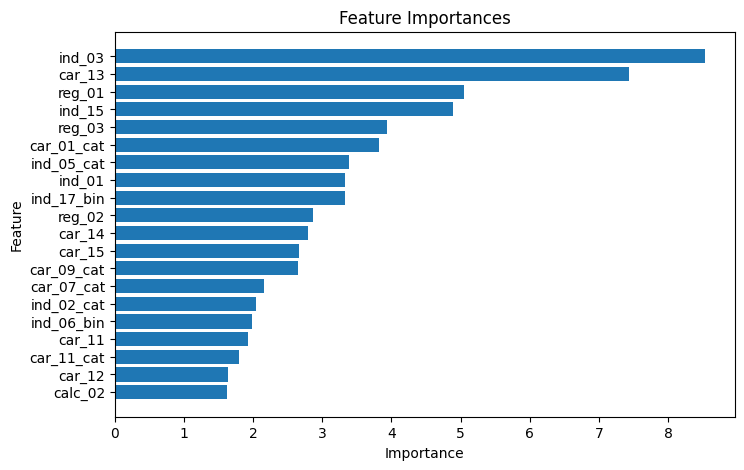

In [0]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

feat_imp = feat_imp.head(20)

plt.figure(figsize=(8, len(feat_imp) * 0.25))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.title('Feature Importances')
plt.show()

In [0]:
X_test = spark.read.table(training_params["test_set_path"])
X_test = X_test.toPandas()

In [0]:
submissions_path = f"/Volumes/{CATALOG}/{SCHEMA}/{VOLUME}/submissions"
is_major_update = run_params["is_major_update"]
submitted_files = []

for file in dbutils.fs.ls(submissions_path):
    if file.name.startswith("submission") and file.name.endswith(".csv"):
        submitted_files.append((file.name, file.modificationTime))

submitted_files.sort(key=lambda x: x[1], reverse=True)
latest_submitted_file = submitted_files[0]
latest_version = latest_submitted_file[0].split("_v")[1].split(".csv")[0]

if is_major_update:
    # add epsilon to prevent integer stalement (e.g. "1" stays "1")
    this_version = math.ceil(float(latest_version)+0.01)
else:
    this_version = round(float(latest_version) + 0.1, ndigits=1)

print(f"this version is: v{this_version}")

this version is: v0.7


In [0]:
preds = model.predict_proba(X_test)[:, 1]

preds_df = pd.DataFrame(
    {"id": X_test["id"], "target": preds}
).sort_values("id")

preds_df.to_csv(
    f"{submissions_path}/submission_v{this_version}.csv",
    index=False
)
